Image manipulation demonstration created by Alex Frye, for use in Dr. Hoover's EE/CENG 441/541 Computer Vision class

In [1]:
import skimage
from skimage import io
from skimage import data
from skimage.transform import resize
from skimage.transform import rotate
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import linalg as LA
import time
from scipy import signal
from scipy import linalg
from scipy.ndimage import gaussian_filter

from Lab3_lib import *

In [2]:
header = 'P4Images/'
im_per_group = [64, 128]
im_maj_groups = ['TestImages/', 'TrainingImages/']
im_min_groups = ['Boat', 'Cabinet', 'Car', 'Chair', 'Cup', 'FlashLight', 'Handle', 'HoseReel',
                'ibook01', 'imac04', 'imac98', 'Keyboard', 'LED', 'Light1', 'Light2',
                'Mug', 'Scooter', 'SprayBottle', 'Stapler', 'Trash']
im_proc = ['Unprocessed/', 'Processed/']
im_size = ['32/', '64/']
im_head = 'img_'
im_foot = '.png'
im_ans = 'RandAng.txt'

# Grab testing data
im_testing = []
for i in range(len(im_min_groups)):
    im_testing.append([])
    for j in range(im_per_group[0]):
        head = header + im_maj_groups[0] + im_min_groups[i] + im_size[0] + im_proc[0] + im_head
        temp = io.imread(head + str(j) + im_foot, as_gray = True)
        im_testing[i].append(temp)

# Grab testing answers
im_testing_ans_str = header + im_maj_groups[0] + im_ans
with open (im_testing_ans_str, "r") as myfile:
    data=myfile.read()

im_testing_ans = data.split(',')
for i in range(len(im_testing_ans)):
    im_testing_ans[i] = float(im_testing_ans[i])

# Grab training data
im_training_proc = []
im_training_unproc = []
for i in range(len(im_min_groups)):
    im_training_proc.append([])
    im_training_unproc.append([])
    for j in range(im_per_group[1]):
        head = header + im_maj_groups[1] + im_min_groups[i] + im_size[1] + im_proc[0] + im_head
        temp = io.imread(head + str(j) + im_foot, as_gray = True)
        im_training_unproc[i].append(temp)
        
        head = header + im_maj_groups[1] + im_min_groups[i] + im_size[1] + im_proc[1] + im_head
        temp = io.imread(head + str(j) + im_foot, as_gray = True)
        im_training_proc[i].append(temp)

# Compute training answers
im_training_ans = np.linspace(0, 2*np.pi, 128)

In [3]:
x, u, sv, vt, m = x_svd_m_from_image_sets(im_training_unproc)

In [4]:
g, ug, svg, vtg, mg = g_svd_m_from_x(x)

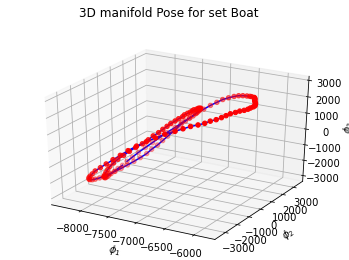

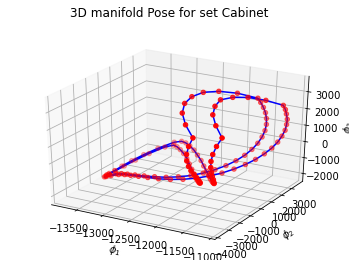

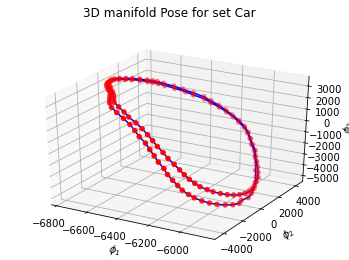

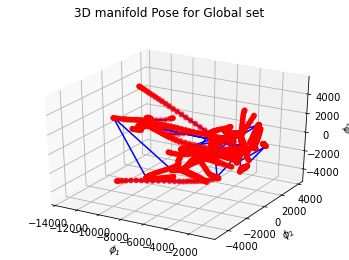

In [5]:
plot_3d_manifold(m, im_min_groups, 0)
plot_3d_manifold(m, im_min_groups, 1)
plot_3d_manifold(m, im_min_groups, 2)
plot_3d_manifold(mg, im_min_groups)

Looking at the different 3D subspaces, the car and boat datasets are almost circular, resulting in a large distinction between different image rotations. On the other hand, the Cabinet dataset crosses over itself, requiring a higher-dimensional subspace to accurately estimate the pose of some objects. The global dataset takes this to the extreme, turning into a jumbled mess quickly.

Looking very closely at these plots though, most have two nearly-overlapping traces, where the object could be mistaken for being off by 180 degrees. For the cabinet, part of the dataset is tightly together, while on the other side it is spread out. This is likely because of the easily distinguishable handles on the front. When the front can be seen, it is trivial to determine its exact orientation, but differentiating the two sides is near-impossible.

In contrast, the car dataset is almost all overlapping, as the front and back of the car are only distinguishable by the grille and rear-view mirrors, small and easily missed details.

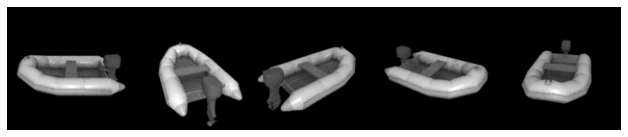

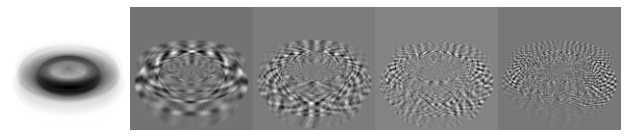

In [6]:
display_eigenimages(im_training_unproc[0], u[0], [0, 25, 50, 75, 100])

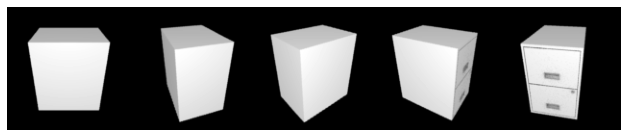

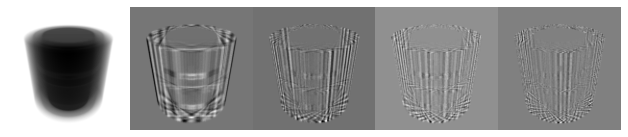

In [7]:
display_eigenimages(im_training_unproc[1], u[1], [0, 25, 50, 75, 100])

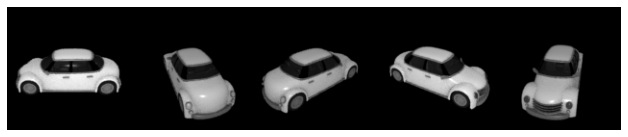

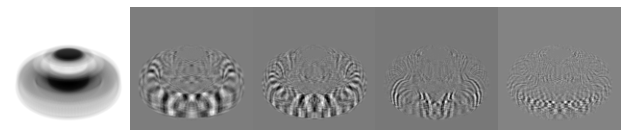

In [8]:
display_eigenimages(im_training_unproc[2], u[2], [0, 25, 50, 75, 100])

Part 2

In [9]:
data = []
k_all = []
k_all_list = [0.20, 0.40, 0.55, 0.70, 0.80, 0.90, 0.95]

# Compute data and min_vectors for err = k_all_list
for i in range(20):
    data.append(computeER(x[i], sv[i]))
    k_all.append([])
    for j in range(len(k_all_list)):
        k_all[i].append(computeER(x[i], sv[i], k_all_list[j]))

# Compute the same for the global system
data.append(computeER(g, svg))
k_all.append([])
for j in range(len(k_all_list)):
    k_all[20].append(computeER(g, svg, k_all_list[j]))

In [10]:
disp_ER_tables(k_all, k_all_list,im_min_groups)

Minimum basis dimension to reach a given energy recovery for each classifier
[  0.200,  0.400,  0.550,  0.700,  0.800,  0.900,  0.950,] - ER Ratio
[  1.000,  1.000,  1.000,  1.000,  3.000,  7.000, 12.000,] - Boat
[  1.000,  1.000,  1.000,  1.000,  1.000,  1.000,  3.000,] - Cabinet
[  1.000,  1.000,  1.000,  2.000,  3.000,  4.000, 10.000,] - Car
[  1.000,  1.000,  2.000,  3.000,  4.000,  8.000, 16.000,] - Chair
[  1.000,  1.000,  1.000,  1.000,  1.000,  3.000,  5.000,] - Cup
[  1.000,  1.000,  1.000,  2.000,  3.000,  6.000, 12.000,] - FlashLight
[  1.000,  1.000,  2.000,  3.000,  4.000,  6.000, 10.000,] - Handle
[  1.000,  1.000,  1.000,  2.000,  5.000, 11.000, 19.000,] - HoseReel
[  1.000,  1.000,  1.000,  1.000,  3.000,  6.000, 13.000,] - ibook01
[  1.000,  1.000,  1.000,  2.000,  4.000, 10.000, 17.000,] - imac04
[  1.000,  1.000,  1.000,  3.000,  5.000, 13.000, 23.000,] - imac98
[  1.000,  1.000,  3.000,  6.000, 12.000, 21.000, 31.000,] - Keyboard
[  1.000,  1.000,  1.000,  1.000,  2

In the next cell, the energy recovery is plotted as a function of basis dimension for a few different image sets. The global set is one of the worst, requiring 92 basis vectors to obtain a 0.90 energy recovery ratio. That said, the Keyboard set is also quite difficult to downsize, while the trash set is almost perfect, requiring only 2 basis vectors for an energy recovery ratio of 0.95.

[127, 0.9621409505180119]


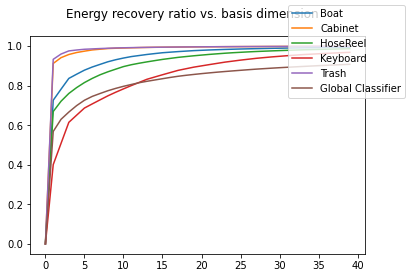

In [11]:
plotER(data, [0, 1, 7, 11, 19, 20], im_min_groups, 40)
print(data[20][127])

Part 3

Here is the user input section (Note: The rest of the code will not run until you go through the menus)

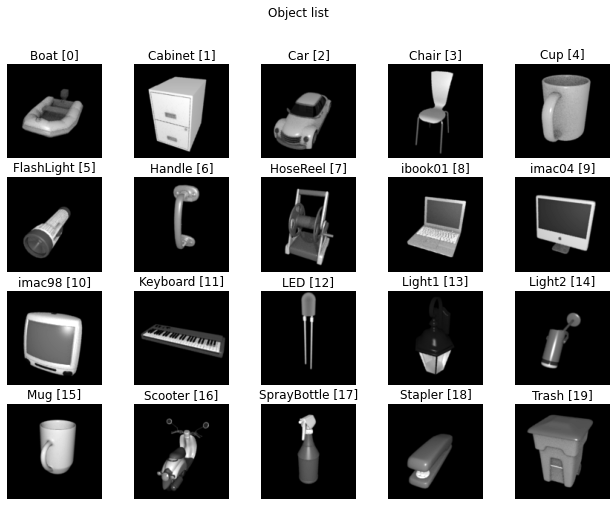

Please enter a number 0-19 to select a test image set: 0
Please enter a number 0-63 to select a specific image: 0
For this set, the recommended k values for a given energy recovery ration are: 
[  0.200,  0.400,  0.550,  0.700,  0.800,  0.900,  0.950,]
[  1.000,  1.000,  1.000,  1.000,  3.000,  7.000, 12.000,]
Please enter a number 0-127 to select a subspace dimension: 1


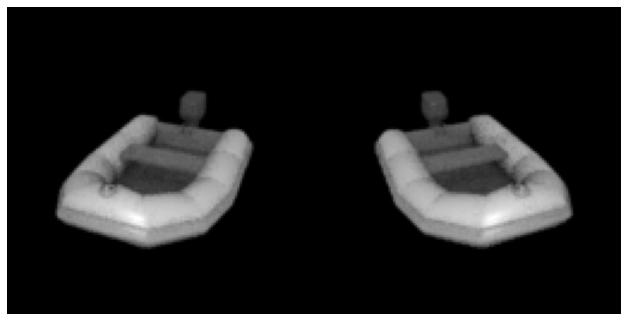

Left is the test image, right is the closest match
True pose = 5.0993, Estimated pose = 4.353703204974831
Error is -0.7455967950251692 Radians, or -42.719549573422924 Degrees
Would you also like to test the global classifier on this object? (y/n): n


In [12]:
image_from_user(im_testing, im_testing_ans, im_training_unproc, im_training_ans, u, m, ug, mg, im_min_groups, k_all, k_all_list)


This section is mostly graph and tables. The next 2 lines compute all of the data for that plotting, and the global classifier takes about 10-15 minutes to compute all of the image pose and classification errors.

If you don't want to wait, I copied the output when I ran it to the 'Example run.pdf' document in this folder.

In [14]:
local_class_data = local_classification_avg_error(im_testing, im_testing_ans, im_training_ans, u, m, k_max=100)

In [ ]:
global_class_data, global_class_accuracy = global_classification_avg_error(im_testing, im_testing_ans, im_training_ans, ug, mg, k_max=100)

The most difficult object for the global classifier to estimate is the LED, since it is so easy to be off by a half-rotation. The local classifier on the other hand, really struggles with the cabinet, and only a little with the LED. 

As far as actual mis-classifications are concerned, 3 basis vectors is enough for 100% accuracy on all datasets.

In [ ]:
plot_class_error(global_class_data, [0, 1, 2, 3, 4], im_min_groups, 'Global Average Error Magnitude (radians)', k_max=30)
plot_class_error(global_class_data, [5, 6, 7, 8, 9], im_min_groups, 'Global Average Error Magnitude (radians)', k_max=30)
plot_class_error(global_class_data, [10, 11, 12, 13, 14], im_min_groups, 'Global Average Error Magnitude (radians)', k_max=30)
plot_class_error(global_class_data, [15, 16, 17, 18, 19], im_min_groups, 'Global Average Error Magnitude (radians)', k_max=30)
plot_class_error(global_class_data, [0, 1, 7, 11, 19], im_min_groups, 'Global Average Error Magnitude (radians)', k_max=30)

In [ ]:
plot_class_error(global_class_accuracy, [0, 1, 2, 3, 4], im_min_groups, 'Global Misclassifications', k_max=30)
plot_class_error(global_class_accuracy, [5, 6, 7, 8, 9], im_min_groups, 'Global Misclassifications', k_max=30)
plot_class_error(global_class_accuracy, [10, 11, 12, 13, 14], im_min_groups, 'Global Misclassifications', k_max=30)
plot_class_error(global_class_accuracy, [15, 16, 17, 18, 19], im_min_groups, 'Global Misclassifications', k_max=30)
plot_class_error(global_class_accuracy, [0, 1, 7, 11, 19], im_min_groups, 'Global Misclassifications', k_max=30)

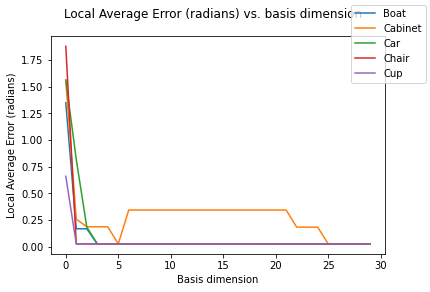

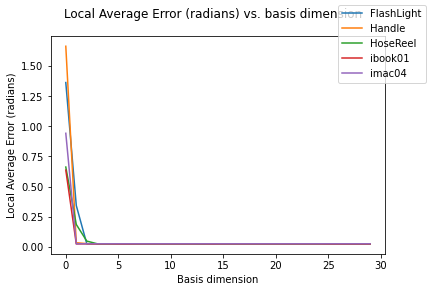

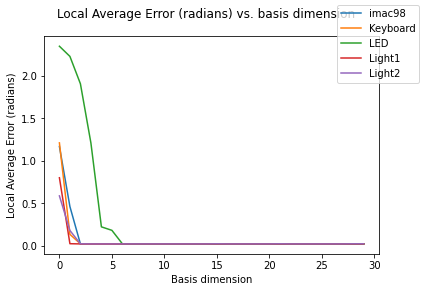

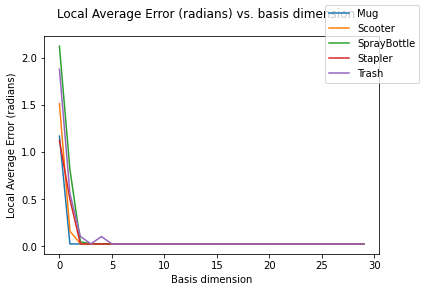

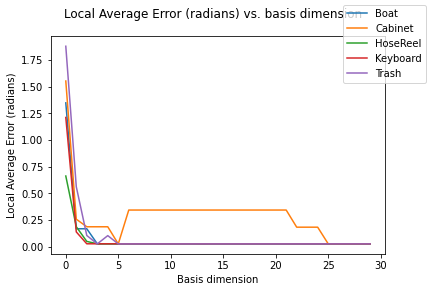

In [15]:
plot_class_error(local_class_data, [0, 1, 2, 3, 4], im_min_groups, 'Local Average Error (radians)', k_max=30)
plot_class_error(local_class_data, [5, 6, 7, 8, 9], im_min_groups, 'Local Average Error (radians)', k_max=30)
plot_class_error(local_class_data, [10, 11, 12, 13, 14], im_min_groups, 'Local Average Error (radians)', k_max=30)
plot_class_error(local_class_data, [15, 16, 17, 18, 19], im_min_groups, 'Local Average Error (radians)', k_max=30)
plot_class_error(local_class_data, [0, 1, 7, 11, 19], im_min_groups, 'Local Average Error (radians)', k_max=30)

In [16]:
disp_class_tables(k_all, k_all_list, local_class_data, 'local', im_min_groups)

Average error (radians) for each local classifier at given Energy recovery ratios
[  0.200,  0.400,  0.550,  0.700,  0.800,  0.900,  0.950,] - ER Ratio
[  0.167,  0.167,  0.167,  0.167,  0.026,  0.026,  0.026,] - Boat
[  0.257,  0.257,  0.257,  0.257,  0.257,  0.257,  0.186,] - Cabinet
[  0.815,  0.815,  0.815,  0.184,  0.025,  0.026,  0.025,] - Car
[  0.025,  0.025,  0.025,  0.025,  0.025,  0.026,  0.026,] - Chair
[  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,] - Cup
[  0.343,  0.343,  0.343,  0.026,  0.025,  0.026,  0.026,] - FlashLight
[  0.035,  0.035,  0.028,  0.025,  0.025,  0.025,  0.025,] - Handle
[  0.187,  0.187,  0.187,  0.049,  0.026,  0.026,  0.026,] - HoseReel
[  0.025,  0.025,  0.025,  0.025,  0.026,  0.025,  0.026,] - ibook01
[  0.026,  0.026,  0.026,  0.026,  0.026,  0.026,  0.026,] - imac04
[  0.464,  0.464,  0.464,  0.025,  0.025,  0.025,  0.025,] - imac98
[  0.138,  0.138,  0.026,  0.026,  0.026,  0.026,  0.026,] - Keyboard
[  2.226,  2.226,  2.226,  2.22

In [ ]:
disp_class_tables(k_all, k_all_list, global_class_data, 'global', im_min_groups)

In [ ]:
disp_class_tables(k_all, k_all_list, global_class_accuracy, 'global', im_min_groups, 'Global misclassifications')